In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import pygraphviz as pgv
import networkx as nx
import numpy as np
from collections import defaultdict
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [49]:
def build_matrix(G, ncells, nmutations):
    mat = np.zeros((ncells, nmutations))
    node_map = defaultdict()
    root = None
    for n in G.nodes():
        if G.in_degree(n) == 0:
            node_map[n] = np.array([0,0,0,0,0])
        elif G.out_degree(n) > 0:
            node_map[n] = np.array([0,0,0,0,0])
            for pred in list(nx.ancestors(G, n)):
                if int(pred) <= nmutations:
                    node_map[n][int(pred) - 1] = 1
            node_map[n][int(n) - 1] = 1
        

    for n in G.nodes():
        # Get all outgoing edges from the node
        out_edges = G.out_edges(n)
        # Extract the target nodes from the edges
        outdegree_nodes = [target for _, target in out_edges if G.out_degree(target) == 0]
        for leaf in outdegree_nodes:
            mat[int(leaf[1:])] = node_map[n]
            
    return mat

In [50]:
def calculate_likelihood(original, inferred, prop):
    l = 0
    fp = prop/2
    fn = prop/2
    fn_weight = np.log(fn) - np.log(1-fn)
    fp_weight = np.log(1-fp) - np.log(fp)
    one_cnt = 0
    for r in range(original.shape[0]):
        zero_elem = np.where(original[r] == 0, 1, 0)
        one_elem = np.where(original[r] == 1, 1, 0)
        l += (fn_weight * np.dot(zero_elem, inferred[r]) + fp_weight * np.dot(one_elem, inferred[r]))
        one_cnt += sum(inferred[r])
    return l

In [51]:
def calculate_likelihood_rc(inferred, variant, total, prop):
    l = 0
    #fp_error_rate = prop/2 + (1 - prop) * 0.50 
    fp_error_rate = prop/2
    alpha = fp_error_rate * 15
    beta = (1-fp_error_rate) * 15
    for r in range(inferred.shape[0]):
        prof = np.zeros(inferred.shape[1])
        for c in range(inferred.shape[1]):
            if total[r,c] > 0.5:
                prof[c] = scipy.stats.betabinom.logpmf(variant[r,c], total[r,c], 1, 1) - scipy.stats.betabinom.logpmf(variant[r,c], total[r,c], alpha, beta)
        l += np.dot(prof, inferred[r])
    return l

In [52]:
def remove_duplicate_legend_entries(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(unique.values(), unique.keys())

# Imputation Methods Comparison

### Parameters

In [33]:
# Variable Parameters 
ncells_per_sample = 2000
timepoints = [3, 5, 7]
error_rates = [0.01, 0.05, 0.075, 0.10, 0.125, 0.15]
num_replicates = 20

# Fixed Parameters
nmutations = 5

## Plot Normalized Matrix Error

### Box Plot

0 0
0 1
0 2
0 3
0 4
0 5
1 0
1 1
1 2
1 3
1 4
1 5
2 0
2 1
2 2
2 3
2 4
2 5


<Figure size 1800x1200 with 0 Axes>

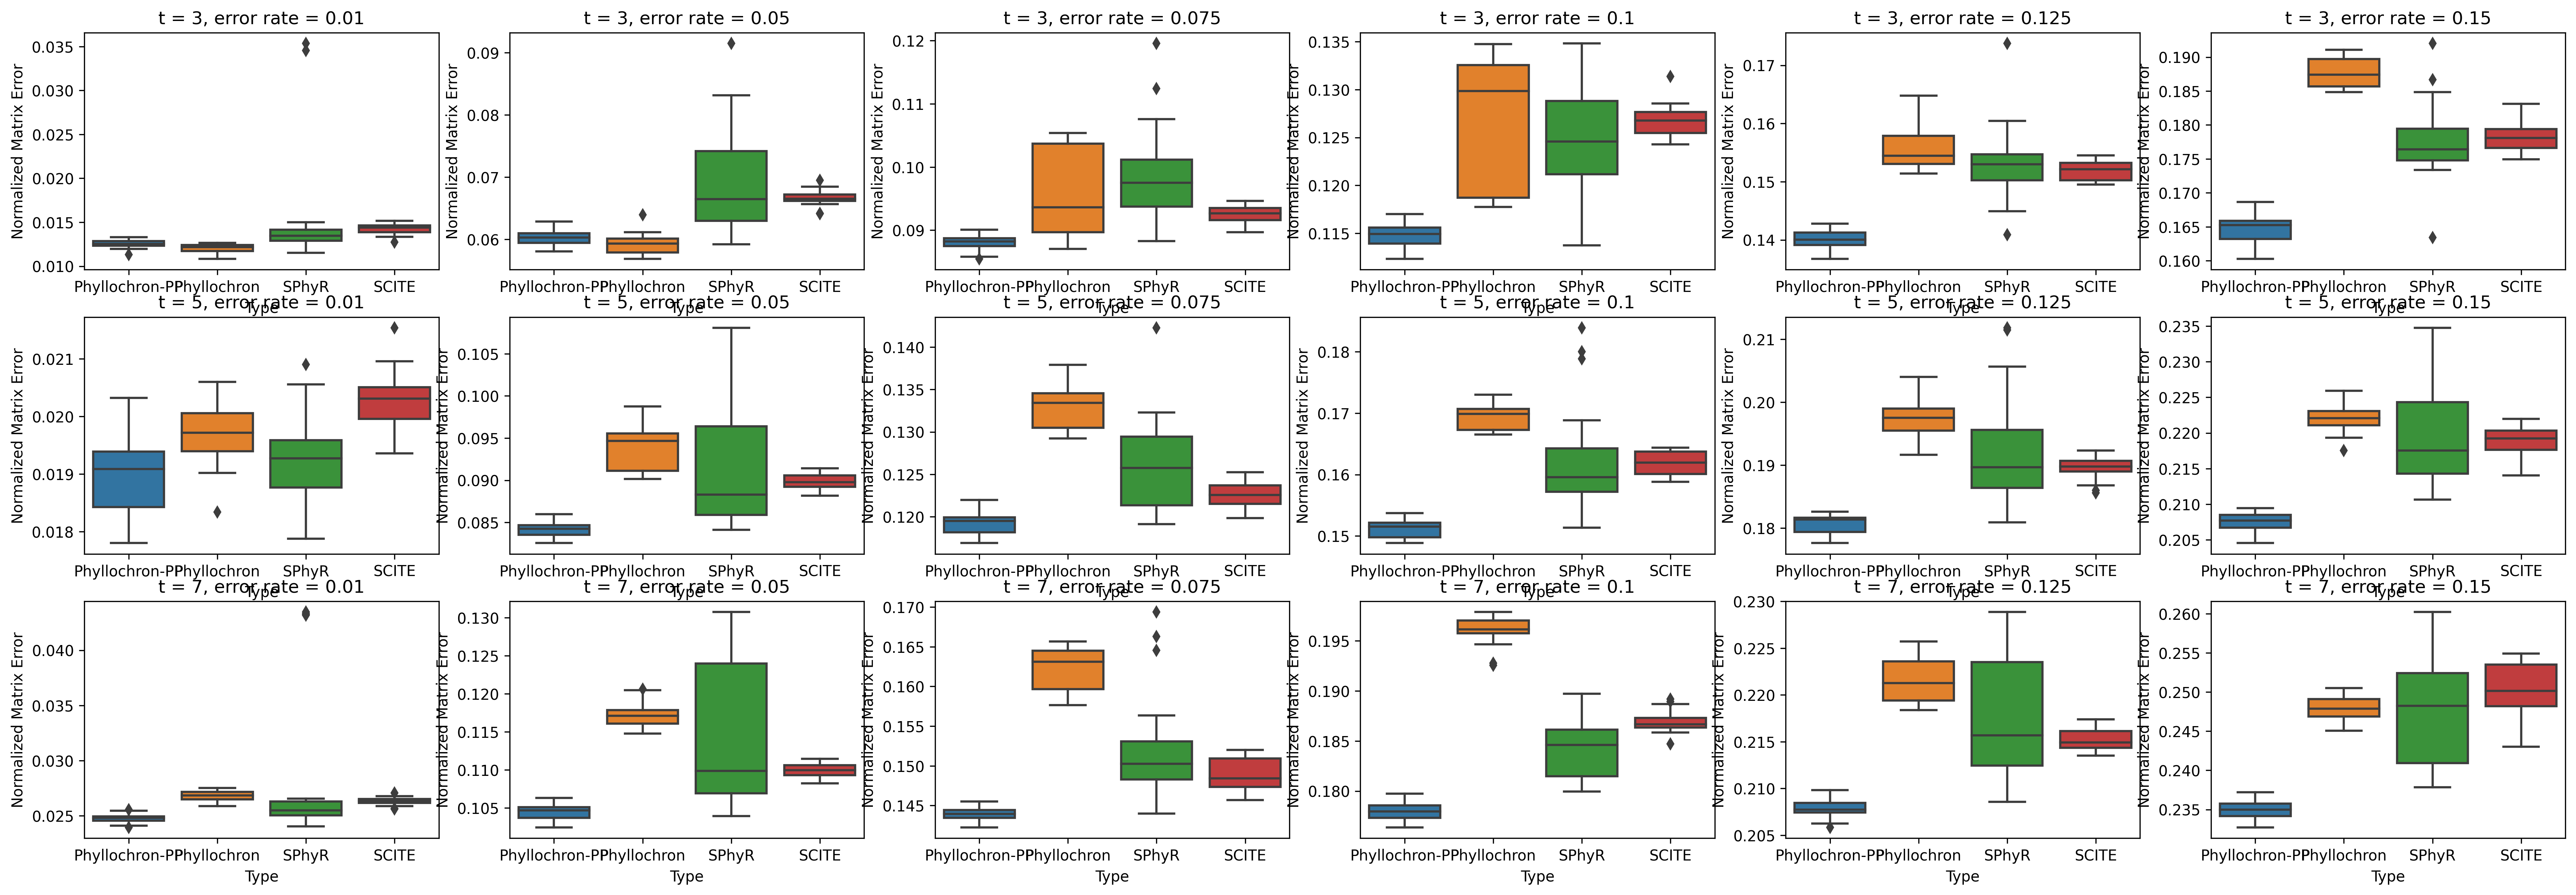

In [46]:
plt.figure()
fig, axs = plt.subplots(len(timepoints), len(error_rates), figsize=(30, 10))
idx = 0
for i, t in enumerate(timepoints):
    for j, prop in enumerate(error_rates):
        print(i,j)
        phyllochron_pp_diffs = []
        phyllochron_diffs = []
        SPhyR_diffs = []
        SCITE_diffs = []
        for sd in range(num_replicates + 1):
            if sd < num_replicates:
                og_character_matrix = pd.read_csv(f'../simulations/ground_truth/gt_imputation_{t}_{prop}_{sd}.csv').values[:, 1:]
                phyllochron_df = pd.read_csv(f'../simulations/Phyllochron/phyllochron_{t}_{prop}_{sd}_B.csv')
                phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP/phyllochron_pp_{t}_{prop}_{sd}_B.csv')
                sphyr_df = pd.read_csv(f'../simulations/SPhyR/sphyr_{t}_{prop}_{sd}.txt', sep=' ',skiprows=2, header=None)


                gv = pgv.AGraph(f'../simulations/SCITE/scite_{t}_{prop}_{sd}_ml0.gv', strict=False, directed=True)
                G = nx.DiGraph(gv)
                SCITE_character_matrix = build_matrix(G, t * ncells_per_sample, nmutations)
                
                SPhyR_character_matrix = sphyr_df.values
                phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
                phyllochron_pp_diffs.append(np.sum(np.abs(og_character_matrix - phyllochron_pp_character_matrix))/(ncells_per_sample * nmutations * t))
                phyllochron_diffs.append(np.sum(np.abs(og_character_matrix - phyllochron_character_matrix))/(ncells_per_sample * nmutations * t))
                SPhyR_diffs.append(np.sum(np.abs(og_character_matrix - SPhyR_character_matrix))/(ncells_per_sample * nmutations * t))
                SCITE_diffs.append(np.sum(np.abs(og_character_matrix - SCITE_character_matrix))/(ncells_per_sample * nmutations * t))

            idx += 1

        data = pd.DataFrame({'Type': num_replicates*['Phyllochron-PP'] + num_replicates*['Phyllochron'] + num_replicates*['SPhyR'] + num_replicates*['SCITE'], 'Normalized Matrix Error':phyllochron_pp_diffs + phyllochron_diffs + SPhyR_diffs + SCITE_diffs})
        #axs[i,j].set_ylim(0, 0.20)
        sns.boxplot(x='Type', y='Normalized Matrix Error', data=data, ax = axs[i,j])
        axs[i,j].set_title(f't = {t}, error rate = {prop}')
plt.show()

### Line Plot

0 0
0 1
0 2
0 3
0 4
0 5
1 0
1 1
1 2
1 3
1 4
1 5
2 0
2 1
2 2
2 3
2 4
2 5


NameError: name 'remove_duplicate_legend_entries' is not defined

<Figure size 1800x1200 with 0 Axes>

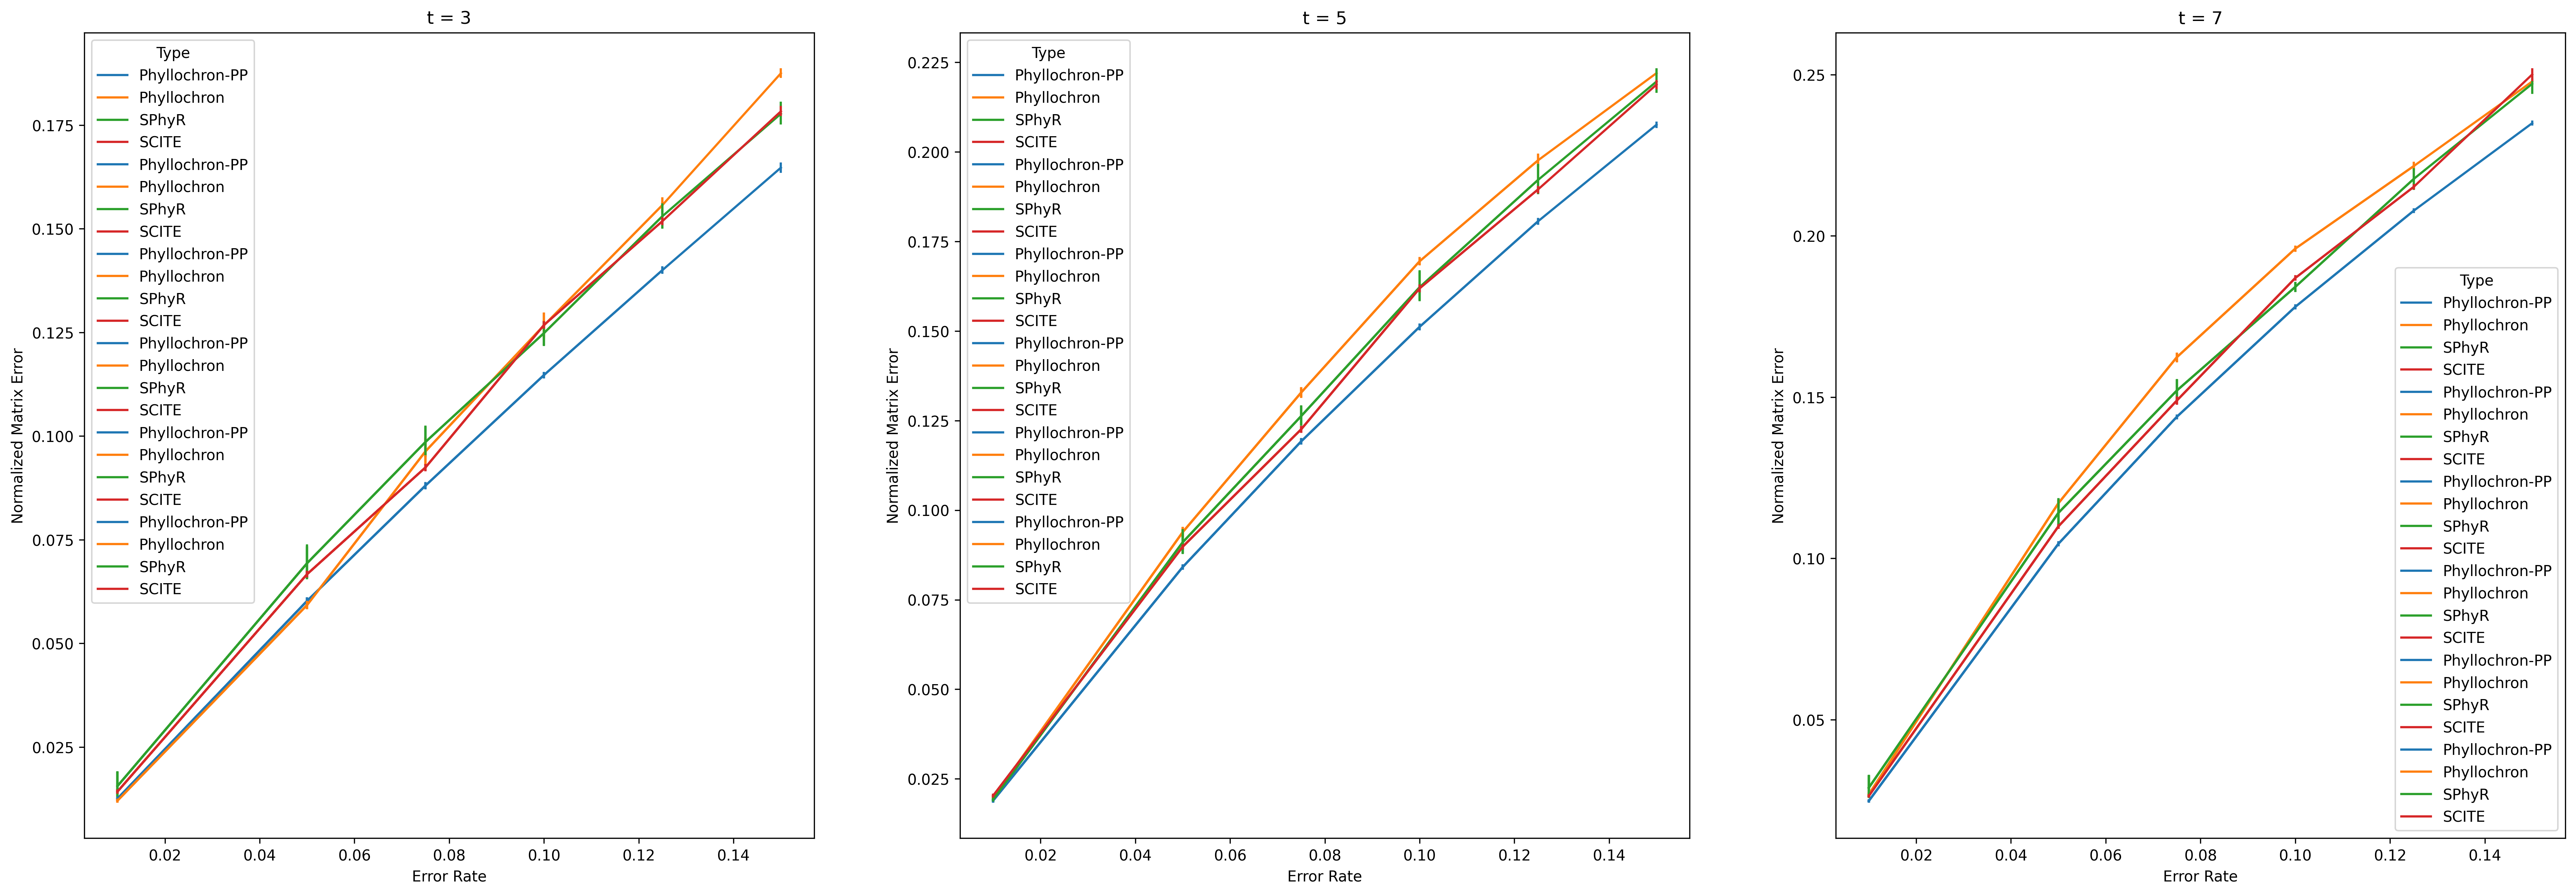

In [48]:
plt.figure()
fig, axs = plt.subplots(1, len(timepoints), figsize=(15, 5))
idx = 0
for i, t in enumerate(timepoints):
    all_data = []
    for j, prop in enumerate(error_rates):
        print(i,j)
        phyllochron_pp_diffs = []
        phyllochron_diffs = []
        SPhyR_diffs = []
        SCITE_diffs = []
        for sd in range(num_replicates + 1):
            if sd < num_replicates:
                og_character_matrix = pd.read_csv(f'../simulations/ground_truth/gt_imputation_{t}_{prop}_{sd}.csv').values[:, 1:]
                phyllochron_df = pd.read_csv(f'../simulations/Phyllochron/phyllochron_{t}_{prop}_{sd}_B.csv')
                phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP/phyllochron_pp_{t}_{prop}_{sd}_B.csv')
                sphyr_df = pd.read_csv(f'../simulations/SPhyR/sphyr_{t}_{prop}_{sd}.txt', sep=' ',skiprows=2, header=None)


                gv = pgv.AGraph(f'../simulations/SCITE/scite_{t}_{prop}_{sd}_ml0.gv', strict=False, directed=True)
                G = nx.DiGraph(gv)
                SCITE_character_matrix = build_matrix(G, t * ncells_per_sample, nmutations)
                
                SPhyR_character_matrix = sphyr_df.values
                phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
                phyllochron_pp_diffs.append(np.sum(np.abs(og_character_matrix - phyllochron_pp_character_matrix))/(ncells_per_sample * nmutations * t))
                phyllochron_diffs.append(np.sum(np.abs(og_character_matrix - phyllochron_character_matrix))/(ncells_per_sample * nmutations * t))
                SPhyR_diffs.append(np.sum(np.abs(og_character_matrix - SPhyR_character_matrix))/(ncells_per_sample * nmutations * t))
                SCITE_diffs.append(np.sum(np.abs(og_character_matrix - SCITE_character_matrix))/(ncells_per_sample * nmutations * t))

            idx += 1

        data = pd.DataFrame({'Error Rate': (4*num_replicates)*[prop],'Type': num_replicates*['Phyllochron-PP'] + num_replicates*['Phyllochron'] + num_replicates*['SPhyR'] + num_replicates*['SCITE'], 'Normalized Matrix Error':phyllochron_pp_diffs + phyllochron_diffs + SPhyR_diffs + SCITE_diffs})
        #axs[i,j].set_ylim(0, 0.20)
        #sns.boxplot(x='Type', y='Normalized Matrix Error', data=data, ax = axs[i,j])
        axs[i].set_title(f't = {t}')
        all_data.append(data)
        data_final= pd.concat(all_data, axis=0, ignore_index=True)
        sns.lineplot(data=data_final, x='Error Rate', y="Normalized Matrix Error", hue="Type", err_style="bars", ax=axs[i])

# Apply function to each subplot
for ax in axs:
    remove_duplicate_legend_entries(ax)

plt.show()

## Plot Likelihood


<Figure size 1800x1200 with 0 Axes>

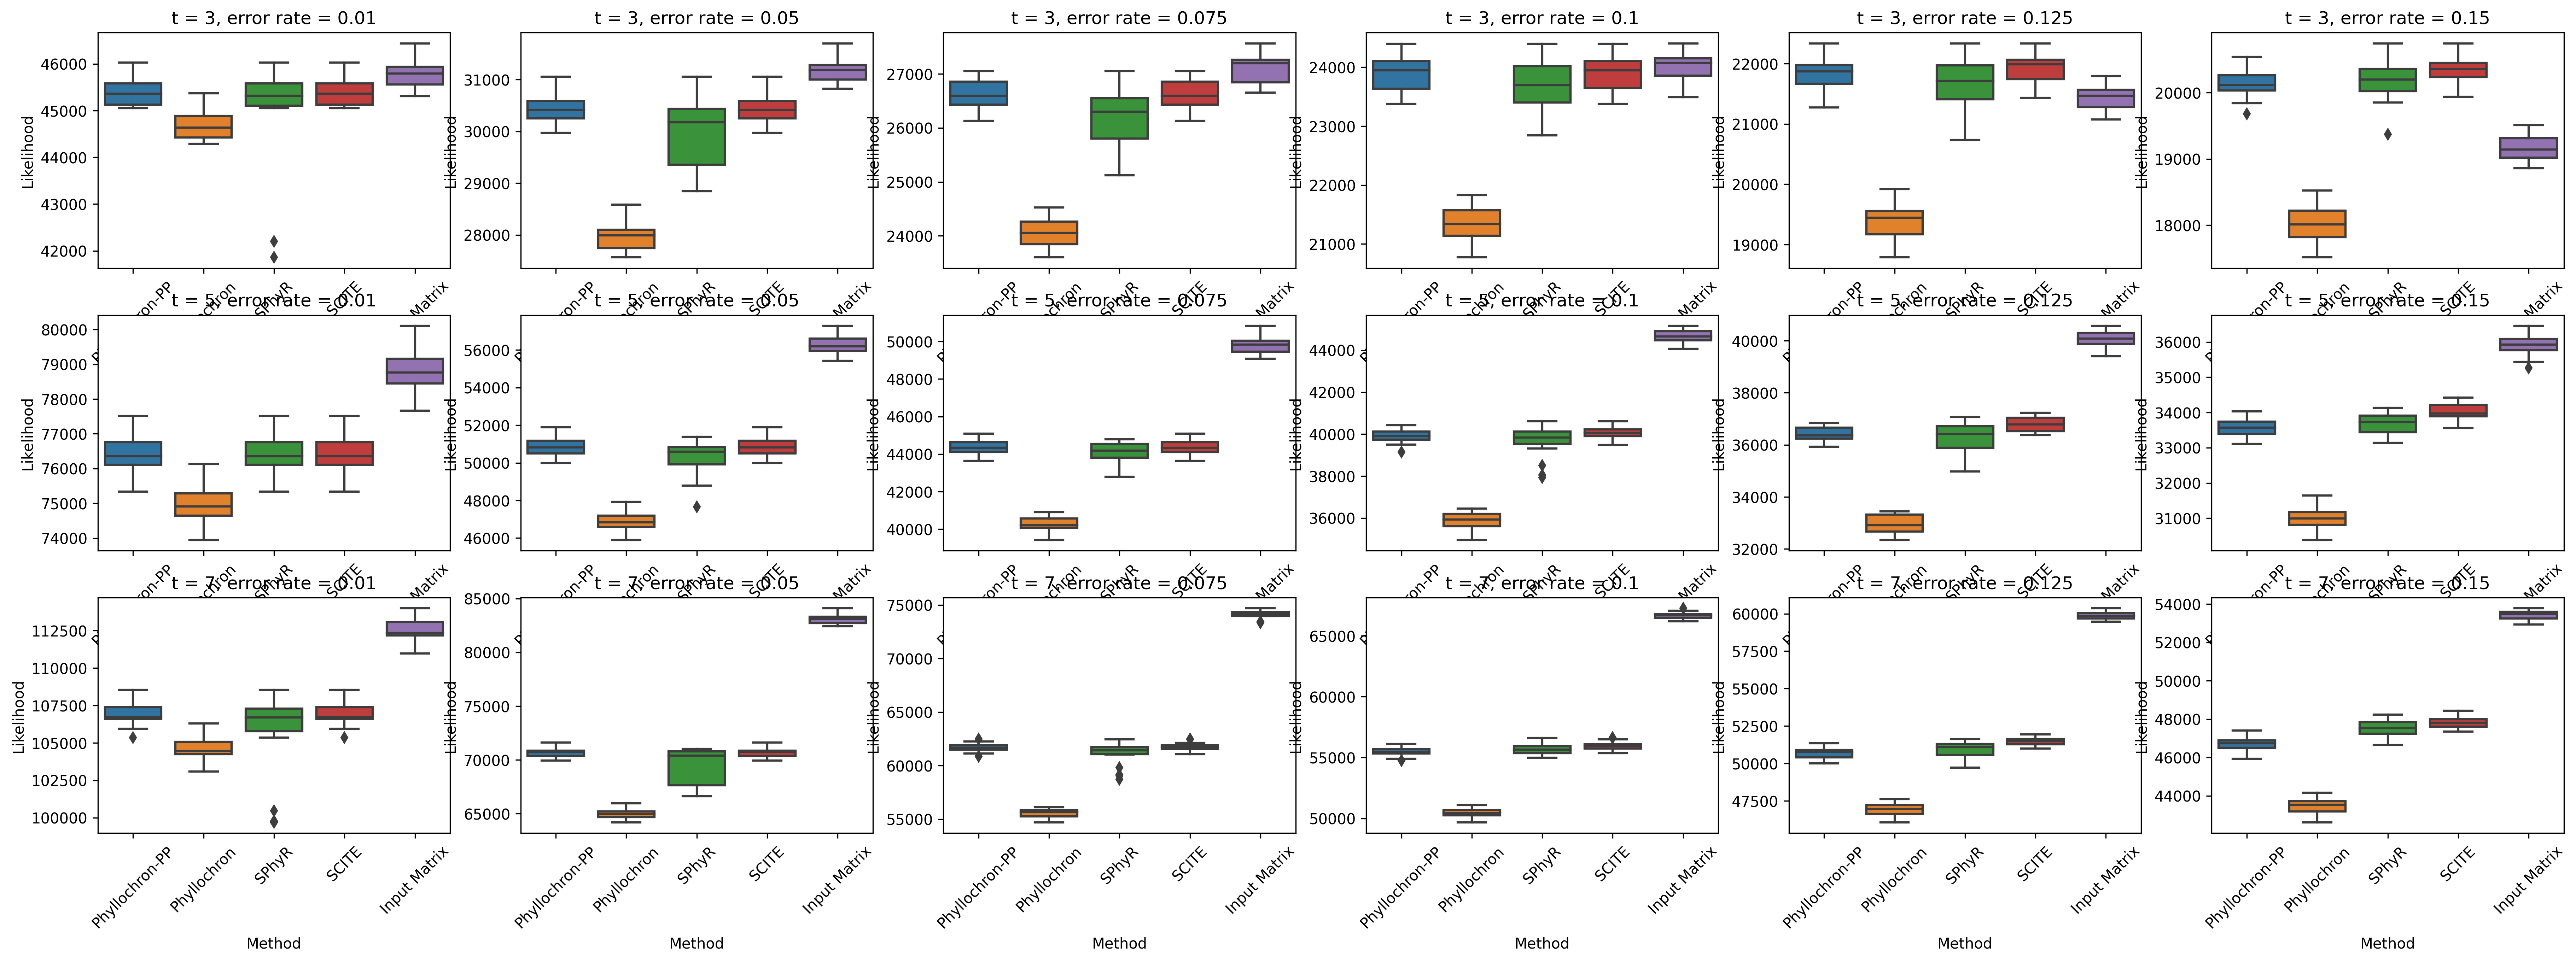

In [57]:
plt.figure()
fig, axs = plt.subplots(len(timepoints), len(error_rates), figsize=(30, 10))
idx = 0
for i, t in enumerate(timepoints):
    for j, prop in enumerate(error_rates):
        phyllochron_pp_diffs = []
        phyllochron_diffs = []
        SPhyR_diffs = []
        SCITE_diffs = []
        input_diffs = []
        for sd in range(num_replicates + 1):
            if sd < num_replicates:
                og_character_matrix = pd.read_csv(f'../simulations/ground_truth/gt_imputation_{t}_{prop}_{sd}.csv').values[:, 1:]
                phyllochron_df = pd.read_csv(f'../simulations/Phyllochron/phyllochron_{t}_{prop}_{sd}_B.csv')
                phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP/phyllochron_pp_{t}_{prop}_{sd}_B.csv')
                sphyr_df = pd.read_csv(f'../simulations/SPhyR/sphyr_{t}_{prop}_{sd}.txt', sep=' ',skiprows=2, header=None)
                input_df = pd.read_csv(f'../simulations/ground_truth/sphyr_{t}_{prop}_{sd}.txt', sep='\t',skiprows=2, header=None)


                gv = pgv.AGraph(f'../simulations/SCITE/scite_{t}_{prop}_{sd}_ml0.gv', strict=False, directed=True)
                G = nx.DiGraph(gv)
                SCITE_character_matrix = build_matrix(G, t * ncells_per_sample, nmutations)
                
                SPhyR_character_matrix = sphyr_df.values
                input_character_matrix = input_df.values.astype(int) 
                phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
                
                input_diffs.append(calculate_likelihood(input_character_matrix, og_character_matrix, prop))
                phyllochron_pp_diffs.append(calculate_likelihood(input_character_matrix,  phyllochron_pp_character_matrix, prop))
                phyllochron_diffs.append(calculate_likelihood(input_character_matrix, phyllochron_character_matrix, prop))
                SPhyR_diffs.append(calculate_likelihood(input_character_matrix, SPhyR_character_matrix, prop))
                SCITE_diffs.append(calculate_likelihood(input_character_matrix, SCITE_character_matrix, prop))
                if phyllochron_pp_diffs[-1] < phyllochron_diffs[-1]:
                    print(t, prop, phyllochron_pp_diffs[-1],  phyllochron_diffs[-1])
                
            idx += 1

        data = pd.DataFrame({'Method': num_replicates*['Phyllochron-PP'] + num_replicates*['Phyllochron'] + num_replicates*['SPhyR'] + num_replicates*['SCITE'] + num_replicates*['Ground Truth'], 'Likelihood':phyllochron_pp_diffs + phyllochron_diffs + SPhyR_diffs + SCITE_diffs + input_diffs})
        axs[i,j].tick_params(axis='x', labelrotation=45)
        #axs[i,j].set_ylim(12000, 110000)
        sns.boxplot(x='Method', y='Likelihood', data=data, ax = axs[i,j])
        axs[i,j].set_title(f't = {t}, error rate = {prop}')
plt.show()